In [1]:
import self_supervised_v1
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../Share/')
import baseline, config

import warnings
warnings.filterwarnings('ignore')

SUBJECT = "Hunmin"
Threshold_K = 4
trainer = baseline.ModelTrainer(config, subject=SUBJECT)
trainer_Carlson = baseline.ModelTrainer(config, subject="Carlson")
trainer_Harold = baseline.ModelTrainer(config, subject="Harold")
trainer_Brian = baseline.ModelTrainer(config, subject="Brian")
trainer_Xianyu = baseline.ModelTrainer(config, subject="Xianyu")

# 초기 학습 데이터
X_init, y_init, X_init_test, y_init_test = trainer.return_until_K_data(K=Threshold_K, train_ratio=0.8)
print(X_init.shape, y_init.shape, X_init_test.shape, y_init_test.shape)

Dataset 1/58 - Session Exp_2025-05-27/E8331D05289A/
Dataset 2/58 - Session Exp_2025-06-18/E9AD0E7DCC2B/
Dataset 3/58 - Session Exp_2025-06-20-v1/E9AD0E7DCC2B/
Dataset 4/58 - Session Exp_2025-06-20-v2/E9AD0E7DCC2B/
(27557, 4, 14, 1) (27557,) (6890, 4, 14, 1) (6890,)


In [2]:
# 모델 생성 및 초기 학습
model = self_supervised_v1.build_model()
result = model.fit(X_init, y_init, validation_data=(X_init_test, y_init_test), epochs=100, batch_size=64, verbose=0)

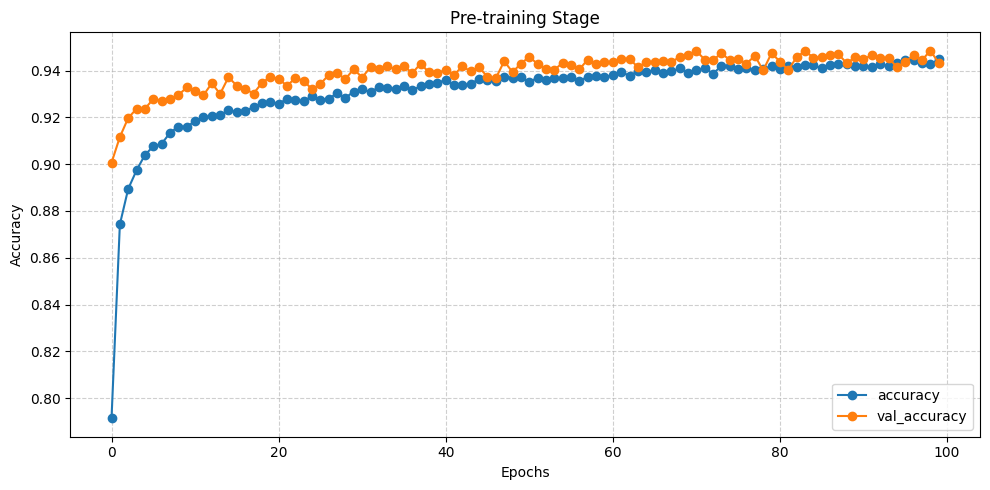

In [3]:
plt.figure(figsize=(10, 5))
plt.plot(result.history['accuracy'], label='accuracy', marker='o')
plt.plot(result.history['val_accuracy'], label='val_accuracy', marker='o')
plt.title('Pre-training Stage')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
# Accuracy 저장 리스트
Same_Session_Test_Acc, Next_Session_Test_Acc = [], []
Unseen_subject_acc_dict = {"H2": [], "C": [], "B": [], "X": []}
trainers_unseen = {
    "H2": trainer_Harold,
    "C": trainer_Carlson,
    "B": trainer_Brian,
    "X": trainer_Xianyu,
}

def evaluate_model(model, data, labels):
    return model.evaluate(data, labels, verbose=0)[1]

# 온라인 학습 루프
for session in range(Threshold_K, len(config.Info_sub_H)):
    # 현재 세션 데이터
    X_train, _, X_test, y_test = trainer.return_K_th_data_only(K=session, train_ratio=0.8)

    # Pseudo-label 생성 및 온라인 업데이트
    pseudo_labels = self_supervised_v1.generate_pseudo_label(model, X_train)
    model = self_supervised_v1.online_update(model, X_train, pseudo_labels)

    # 같은 세션 테스트
    Same_Session_Test_Acc.append(evaluate_model(model, X_test, y_test))

    # 다음 세션 테스트
    next_X, next_y, _, _ = trainer.return_K_th_data_only(K=session + 1, train_ratio=0.8)
    Next_Session_Test_Acc.append(evaluate_model(model, next_X, next_y))

    # Unseen subject 테스트
    for key, trainer_sub in trainers_unseen.items():
        unseen_X, unseen_y, _, _ = trainer_sub.return_until_K_data(K=12, train_ratio=0.8)
        acc = evaluate_model(model, unseen_X, unseen_y)
        Unseen_subject_acc_dict[key].append(acc)

Returning K-th session data: Exp_2025-06-20-v3/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-06-20-v4/E9AD0E7DCC2B/
Dataset 1/12 - Session Exp_2025-07-09-v1/E9AD0E7DCC2B/
Dataset 2/12 - Session Exp_2025-07-09-v2/E9AD0E7DCC2B/
Dataset 3/12 - Session Exp_2025-07-10-v1/E9AD0E7DCC2B/
Dataset 4/12 - Session Exp_2025-07-10-v2/E9AD0E7DCC2B/
Dataset 5/12 - Session Exp_2025-07-11-v1/E9AD0E7DCC2B/
Dataset 6/12 - Session Exp_2025-07-11-v2/E9AD0E7DCC2B/
Dataset 7/12 - Session Exp_2025-07-16-v1/E9AD0E7DCC2B/
Dataset 8/12 - Session Exp_2025-07-16-v2/E9AD0E7DCC2B/
Dataset 9/12 - Session Exp_2025-07-17-v1/E9AD0E7DCC2B/
Dataset 10/12 - Session Exp_2025-07-17-v2/E9AD0E7DCC2B/
Dataset 11/12 - Session Exp_2025-07-23-v1/E9AD0E7DCC2B/
Dataset 12/12 - Session Exp_2025-07-23-v2/E9AD0E7DCC2B/


In [1]:
plt.figure(figsize=(10, 5))
plt.plot(Same_Session_Test_Acc, label='Same session accuracy', marker='o')
plt.plot(Next_Session_Test_Acc, label='Next session accuracy', marker='o')
plt.title('Pre-training Stage')
plt.xlabel('Session Index')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

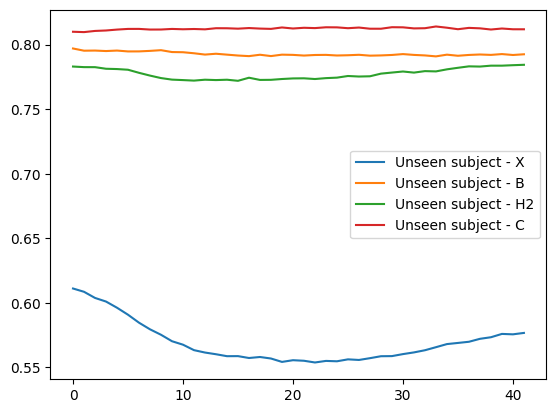

In [6]:
plt.figure(figsize=(10, 6))
for subject, acc_list in Unseen_subject_acc_dict.items():
    plt.plot(acc_list, label=f'Unseen subject: {subject}', marker='o')

plt.title('Online Evaluation on Unseen Subjects')
plt.xlabel('Online Session Index')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()